# Performance notebook

This notebook will analyse the performance of various system components

In [41]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getpass import getpass
import seaborn as sns
import pandas as pd

## Configuration

In [42]:
# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
exclude_courses = [1, 6]

## Load the data from the database

In [43]:
# Configure the database
DB_TYPE = 'postgresql'
DB_DRIVER = 'psycopg2'
DB_USER = 'postgres'
DB_PASS = getpass('Enter your database password: ')
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'kthassistant_local'

DATABASE_URL = f'{DB_TYPE}+{DB_DRIVER}://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(DATABASE_URL)

In [44]:
# Load all data, re-run this to refresh
tables = [
    'chat_configs',
    'chats',
    'content',
    'cookies',
    'courses',
    'faq_snapshots',
    'faqs',
    'feedback',
    'feedback_questions',
    'messages',
    'migratehistory',
    'prompt_handles',
    'sessions',
    'snapshots',
    'urls'
]

dataframes = {}
for table in tqdm(tables):
    dataframes[table] = pd.read_sql_table(table, engine)

  0%|          | 0/15 [00:00<?, ?it/s]

In [45]:
# Print the structure
for table, df in dataframes.items():
    print(f"Structure of DataFrame for table `{table}`")
    print(df.info())
    print("\n")

Structure of DataFrame for table `chat_configs`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              15 non-null     int64         
 1   created_at      15 non-null     datetime64[ns]
 2   modified_at     15 non-null     datetime64[ns]
 3   is_active       15 non-null     bool          
 4   llm_model_name  15 non-null     object        
 5   index_type      15 non-null     object        
dtypes: bool(1), datetime64[ns](2), int64(1), object(2)
memory usage: 747.0+ bytes
None


Structure of DataFrame for table `chats`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                5223 non-null   int64         
 1   created_at        5223 non-nu

## Snapshots

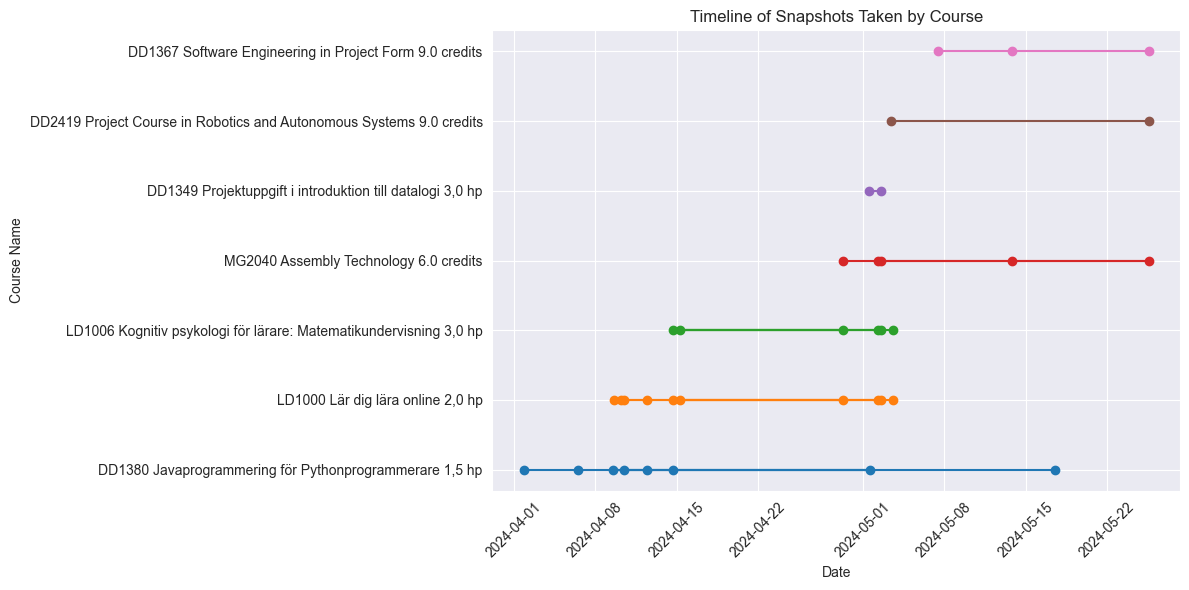

In [46]:
df_snapshots = dataframes['snapshots']
df_courses = dataframes['courses']

df_snapshots_filtered = df_snapshots[~df_snapshots['course_id'].isin(exclude_courses)]
df_snapshots_with_names = pd.merge(df_snapshots_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

course_id_to_name = dict(zip(df_courses['id'], df_courses['name']))

df_snapshots_with_names['course_name'] = df_snapshots_with_names['course_id'].map(course_id_to_name)

sorted_courses = df_snapshots_with_names.groupby('course_name')['created_at'].min().sort_values().index

plt.figure(figsize=(12, 6))

for course_name in sorted_courses:
    group = df_snapshots_with_names[df_snapshots_with_names['course_name'] == course_name]
    plt.plot(group['created_at'], group['course_name'], marker='o', linestyle='-', label=course_name)

plt.title('Timeline of Snapshots Taken by Course')
plt.xlabel('Date')
plt.ylabel('Course Name')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

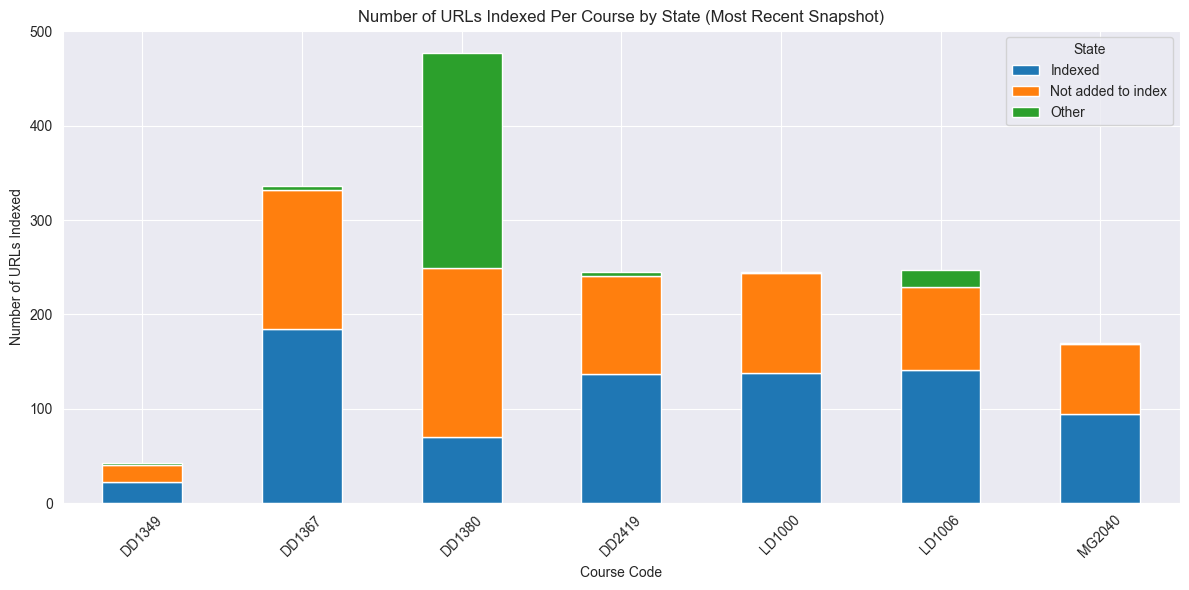

In [47]:
df_snapshots = dataframes['snapshots']
df_courses = dataframes['courses']
df_urls = dataframes['urls']

df_snapshots['created_at'] = pd.to_datetime(df_snapshots['created_at'])
df_urls['created_at'] = pd.to_datetime(df_urls['created_at'])

most_recent_snapshots = df_snapshots.loc[df_snapshots.groupby('course_id')['created_at'].idxmax()]

df_urls_recent_snapshots = df_urls[df_urls['snapshot_id'].isin(most_recent_snapshots['id'])]

df_urls_recent_with_snapshots = pd.merge(df_urls_recent_snapshots, most_recent_snapshots, left_on='snapshot_id', right_on='id', suffixes=('_url', '_snapshot'))
df_urls_recent_with_courses = pd.merge(df_urls_recent_with_snapshots, df_courses, left_on='course_id', right_on='id', suffixes=('', '_course'))

df_urls_recent_filtered = df_urls_recent_with_courses[~df_urls_recent_with_courses['course_id'].isin(exclude_courses)].copy()

df_urls_recent_filtered.loc[:, 'course_code'] = df_urls_recent_filtered['name'].apply(lambda x: x.split()[0])

state_mapping = {
    'indexed': 'Indexed',
    'not_added_to_index': 'Not added to index',
}
df_urls_recent_filtered.loc[:, 'state'] = df_urls_recent_filtered['state'].map(state_mapping).fillna('Other')

urls_per_course_code_state = df_urls_recent_filtered.groupby(['course_code', 'state']).size().unstack(fill_value=0)

urls_per_course_code_state.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Number of URLs Indexed Per Course by State (Most Recent Snapshot)')
plt.xlabel('Course Code')
plt.ylabel('Number of URLs Indexed')
plt.xticks(rotation=45)
plt.legend(title='State')
plt.tight_layout()
plt.show()

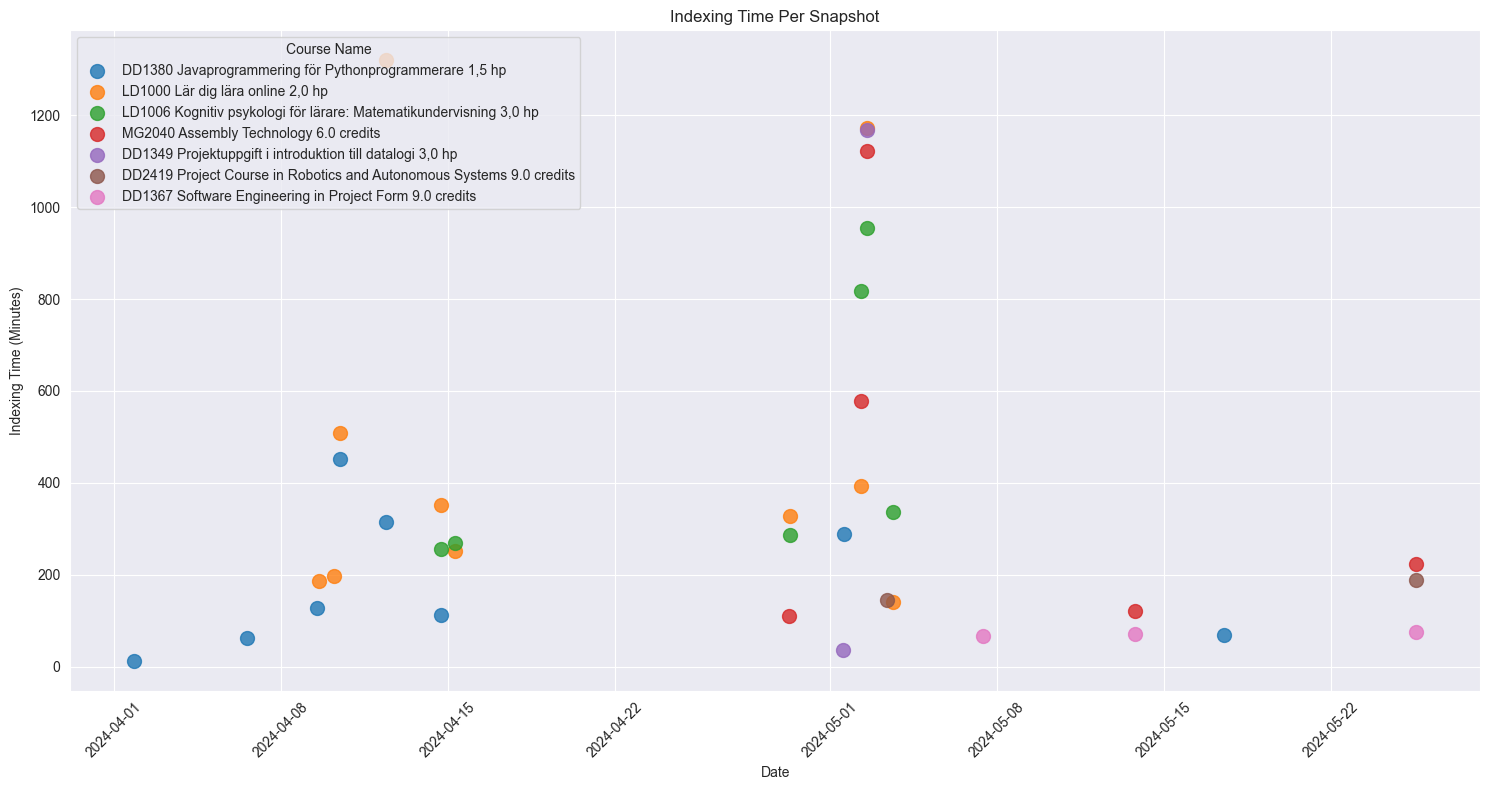

In [48]:
df_snapshots = dataframes['snapshots']
df_courses = dataframes['courses']
df_urls = dataframes['urls']

df_snapshots['created_at'] = pd.to_datetime(df_snapshots['created_at'])
df_urls['created_at'] = pd.to_datetime(df_urls['created_at'])
df_urls['modified_at'] = pd.to_datetime(df_urls['modified_at'])

indexing_times = df_urls.groupby('snapshot_id')['modified_at'].max().reset_index()
indexing_times = pd.merge(indexing_times, df_snapshots[['id', 'created_at', 'course_id']], left_on='snapshot_id', right_on='id')
indexing_times['indexing_time'] = (indexing_times['modified_at'] - indexing_times['created_at']).dt.total_seconds() / 60

indexing_times = pd.merge(indexing_times, df_courses[['id', 'name']], left_on='course_id', right_on='id', suffixes=('', '_course'))

indexing_times_filtered = indexing_times[~indexing_times['course_id'].isin(exclude_courses)].copy()

indexing_times_filtered['course_code'] = indexing_times_filtered['name'].apply(lambda x: x.split()[0])

courses = indexing_times_filtered['name'].unique()
colors = plt.colormaps['tab10'](range(len(courses)))

plt.figure(figsize=(15, 8))

for i, course in enumerate(courses):
    course_data = indexing_times_filtered[indexing_times_filtered['name'] == course]
    plt.scatter(course_data['created_at'], course_data['indexing_time'], color=colors[i], alpha=0.8, s=100, label=course)

plt.title('Indexing Time Per Snapshot')
plt.xlabel('Date')
plt.ylabel('Indexing Time (Minutes)')
plt.legend(title='Course Name', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Prompt handle performance

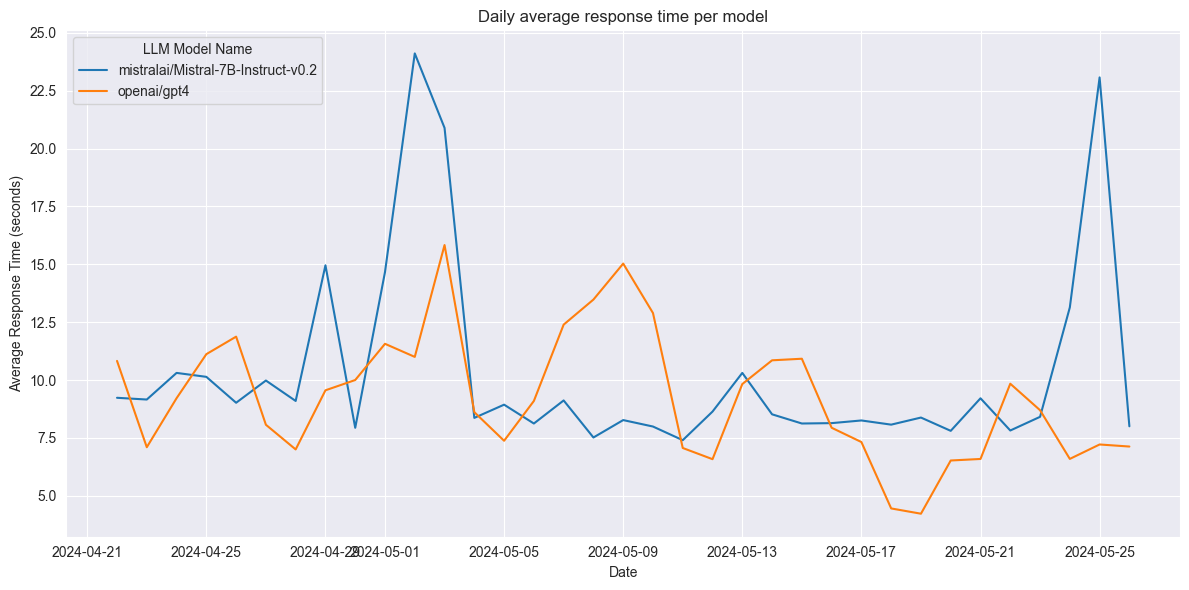

In [49]:
df_prompt_handles = dataframes['prompt_handles']
df_messages = dataframes['messages']
df_chats = dataframes['chats']

df_chats_filtered = df_chats[~df_chats['course_id'].isin(exclude_courses)]

df_messages_filtered = df_messages[df_messages['chat_id'].isin(df_chats_filtered['id'])]

df_prompt_handles_filtered = pd.merge(df_prompt_handles, df_messages_filtered[['prompt_handle_id', 'created_at']], left_on='id', right_on='prompt_handle_id', how='inner')

model_names = ["mistralai/Mistral-7B-Instruct-v0.2", "openai/gpt4"]
df_prompt_handles_filtered = df_prompt_handles_filtered[
    (df_prompt_handles_filtered['state'] == 'finished') &
    (df_prompt_handles_filtered['embedding'].isnull()) &
    (df_prompt_handles_filtered['llm_model_name'].isin(model_names))
]

df_prompt_handles_filtered['response_time_s'] = df_prompt_handles_filtered['response_time_taken_s']

df_prompt_handles_filtered['date'] = df_prompt_handles_filtered['created_at_x'].dt.date
df_prompt_handles_filtered = df_prompt_handles_filtered[df_prompt_handles_filtered['date'] >= pd.to_datetime('2024-04-22').date()]

daily_mean_response_time = df_prompt_handles_filtered.groupby(['date', 'llm_model_name'])['response_time_s'].mean().unstack()

plt.figure(figsize=(12, 6))
for model in daily_mean_response_time.columns:
    plt.plot(daily_mean_response_time.index, daily_mean_response_time[model], marker='', linestyle='-', label=model)

plt.title('Daily average response time per model')
plt.xlabel('Date')
plt.ylabel('Average Response Time (seconds)')
plt.legend(title='LLM Model Name', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

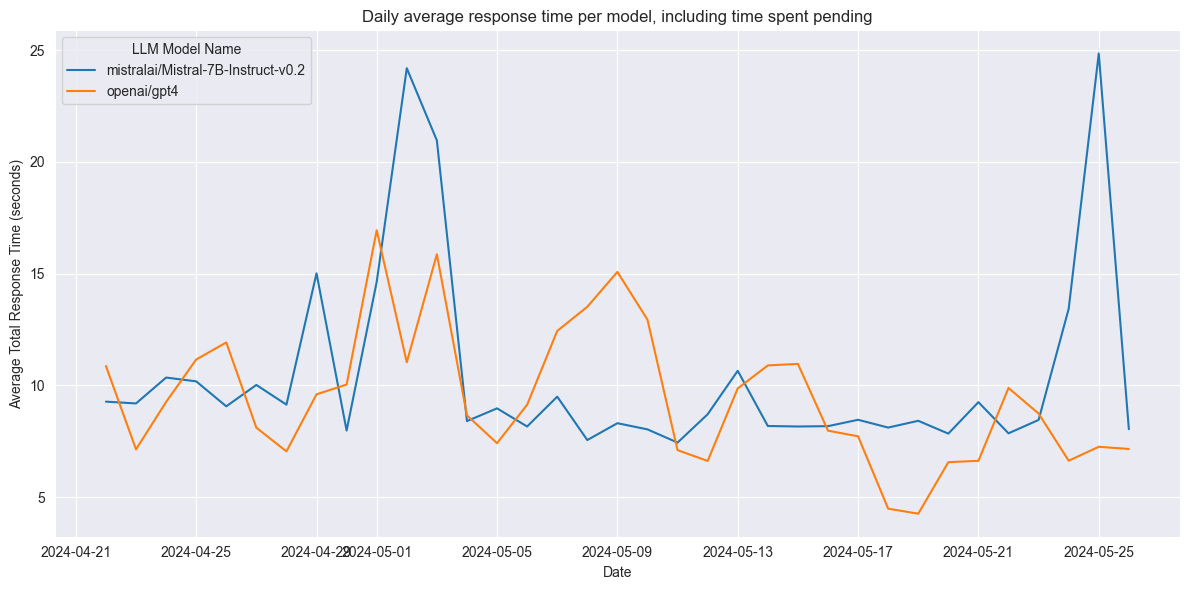

In [50]:
df_prompt_handles = dataframes['prompt_handles']
df_messages = dataframes['messages']
df_chats = dataframes['chats']

df_chats_filtered = df_chats[~df_chats['course_id'].isin(exclude_courses)]

df_messages_filtered = df_messages[df_messages['chat_id'].isin(df_chats_filtered['id'])]

df_prompt_handles_filtered = pd.merge(df_prompt_handles, df_messages_filtered[['prompt_handle_id', 'created_at']], left_on='id', right_on='prompt_handle_id', how='inner')

model_names = ["mistralai/Mistral-7B-Instruct-v0.2", "openai/gpt4"]
df_prompt_handles_filtered = df_prompt_handles_filtered[
    (df_prompt_handles_filtered['state'] == 'finished') &
    (df_prompt_handles_filtered['embedding'].isnull()) &
    (df_prompt_handles_filtered['llm_model_name'].isin(model_names))
]

df_prompt_handles_filtered['total_response_time_s'] = df_prompt_handles_filtered['response_time_taken_s'] + (df_prompt_handles_filtered['time_spent_pending_ms'] / 1000)

df_prompt_handles_filtered = df_prompt_handles_filtered[df_prompt_handles_filtered['total_response_time_s'] <= 200]

df_prompt_handles_filtered['date'] = df_prompt_handles_filtered['created_at_x'].dt.date
df_prompt_handles_filtered = df_prompt_handles_filtered[df_prompt_handles_filtered['date'] >= pd.to_datetime('2024-04-22').date()]

daily_mean_response_time = df_prompt_handles_filtered.groupby(['date', 'llm_model_name'])['total_response_time_s'].mean().unstack()

plt.figure(figsize=(12, 6))
for model in daily_mean_response_time.columns:
    plt.plot(daily_mean_response_time.index, daily_mean_response_time[model], marker='', linestyle='-', label=model)

plt.title('Daily average response time per model, including time spent pending')
plt.xlabel('Date')
plt.ylabel('Average Total Response Time (seconds)')
plt.legend(title='LLM Model Name', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

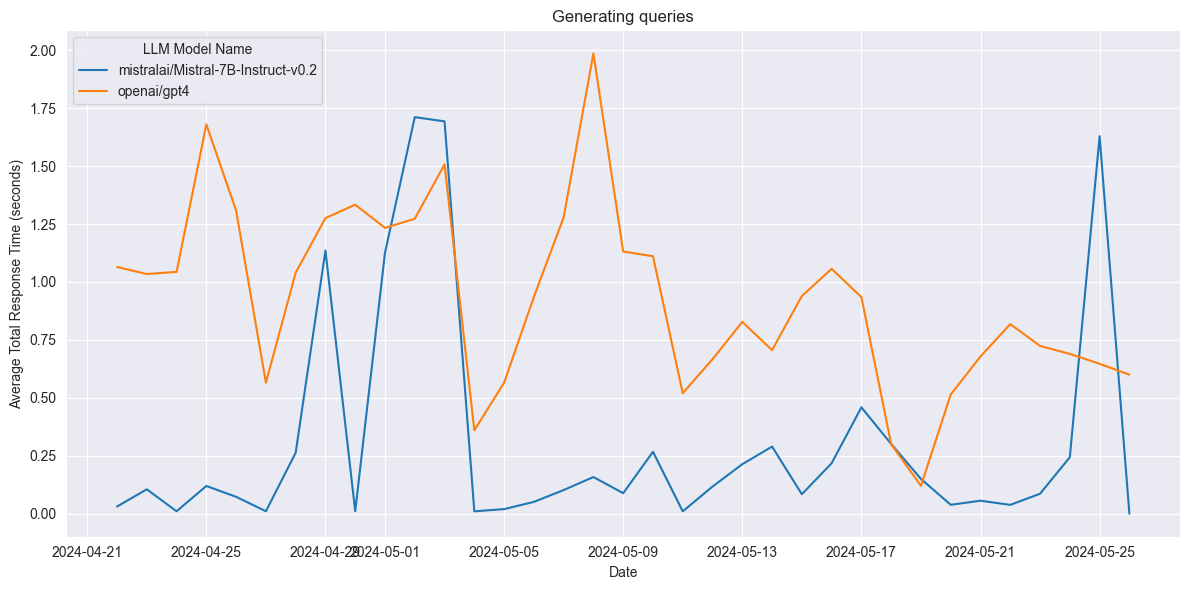

In [76]:
df_prompt_handles = dataframes['prompt_handles']

model_names = ["mistralai/Mistral-7B-Instruct-v0.2", "openai/gpt4"]
prompt_filters = ["You are a query generator", "You are a completion generator"]

df_prompt_handles_filtered = df_prompt_handles[
    (df_prompt_handles['state'] == 'finished') &
    (df_prompt_handles['embedding'].isnull()) &
    (df_prompt_handles['llm_model_name'].isin(model_names)) &
    (df_prompt_handles['prompt'].apply(lambda x: any(filter_str in x for filter_str in prompt_filters)))
].copy()

df_prompt_handles_filtered['total_response_time_s'] = df_prompt_handles_filtered['response_time_taken_s']
df_prompt_handles_filtered['date'] = df_prompt_handles_filtered['created_at'].dt.date

df_prompt_handles_filtered = df_prompt_handles_filtered[df_prompt_handles_filtered['date'] >= pd.to_datetime('2024-04-22').date()]

daily_mean_response_time = df_prompt_handles_filtered.groupby(['date', 'llm_model_name'])['total_response_time_s'].mean().unstack()

plt.figure(figsize=(12, 6))
for model in daily_mean_response_time.columns:
    plt.plot(daily_mean_response_time.index, daily_mean_response_time[model], marker='', linestyle='-', label=model)

plt.title('Generating queries average daily time per model')
plt.xlabel('Date')
plt.ylabel('Average Total Response Time (seconds)')
plt.legend(title='LLM Model Name', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Embedding functions querying performance

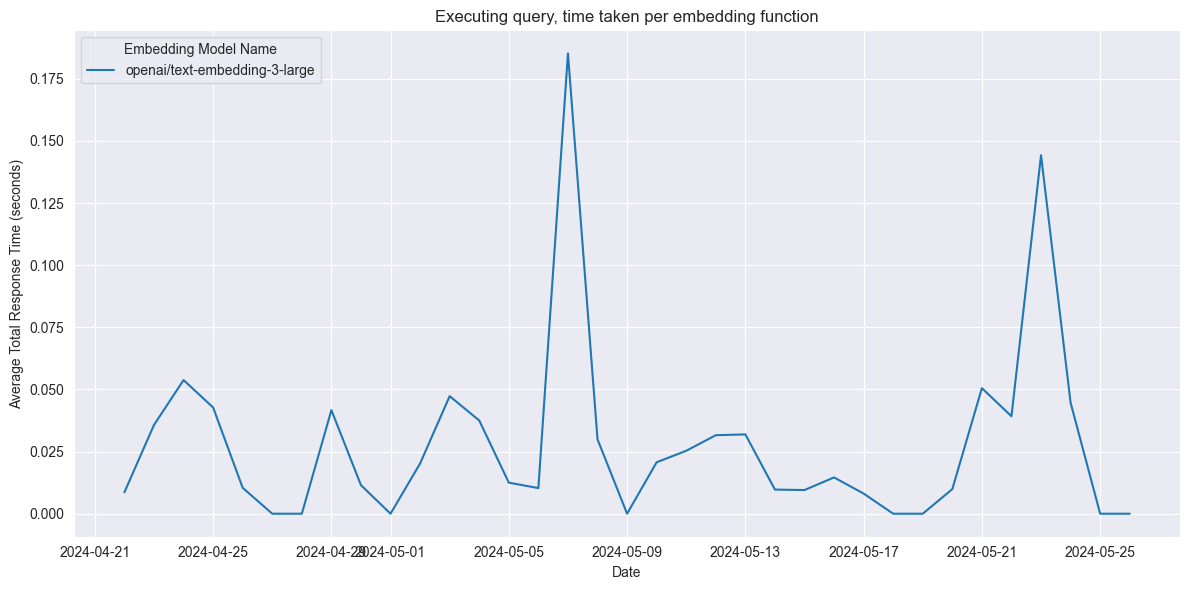

In [87]:
df_prompt_handles = dataframes['prompt_handles']

model_names = ["openai/text-embedding-3-large", "Salesforce/SFR-Embedding-Mistral"]
prompt_filters = ["Document chunk"]

df_prompt_handles_filtered = df_prompt_handles[
    (df_prompt_handles['state'] == 'finished') &
    (df_prompt_handles['response'].isnull()) &  # embedding prompt_handles do not set this field
    (df_prompt_handles['llm_model_name'].isin(model_names)) &
    (df_prompt_handles['prompt'].apply(lambda x: any(filter_str not in x for filter_str in prompt_filters)))
    ].copy()

df_prompt_handles_filtered['total_response_time_s'] = df_prompt_handles_filtered['response_time_taken_s']
df_prompt_handles_filtered['date'] = df_prompt_handles_filtered['created_at'].dt.date

df_prompt_handles_filtered = df_prompt_handles_filtered[df_prompt_handles_filtered['date'] >= pd.to_datetime('2024-04-22').date()]

daily_mean_response_time = df_prompt_handles_filtered.groupby(['date', 'llm_model_name'])['total_response_time_s'].mean().unstack()

plt.figure(figsize=(12, 6))
for model in daily_mean_response_time.columns:
    plt.plot(daily_mean_response_time.index, daily_mean_response_time[model], marker='', linestyle='-', label=model)

plt.title('Executing query, time taken per embedding function')
plt.xlabel('Date')
plt.ylabel('Average Total Response Time (seconds)')
plt.legend(title='Embedding Model Name', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()